In [1]:
import os 

import PIL
import numpy as np
import scipy.stats as sps
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, SVR, LinearSVC
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.datasets import make_moons, make_blobs, make_circles

sns.set(style='dark', font_scale=1.5) 

## SVM в scikit-learn

* Эффективная реализация SVM с **линейным ядром**: [классификация](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC), [регрессия](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVR.html#sklearn.svm.LinearSVR)

* Обычный SVM c произвольными ядрами: [классификация](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC), [регрессия](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#sklearn.svm.SVR)

Описание наиболее важных параметров:

* `C`: Параметр регуляризации. Сила регуляризации обратно пропорциональна `C`. Должна быть строго положительной.

* `kernel`: Тип ядра, который будет использоваться в алгоритме. Это должен быть `linear`, `poly`, `rbf`, `sigmoid`, `precomputed` или callable.

* `degree`: Степень функции ядра полинома (`poly`). Игнорируется другими ядрами.

* `gamma`: Коэффициент ядра для `rbf`, `poly` и `sigmoid`.

Описание наиболее важных атрибутов:

* `support_`: Индексы опорных векторов.

* `support_vectors_`: Опорные вектора.

* `n_support_`: Количество опорных векторов для каждого класса.

* `coef_`: Оценка коэфициентов (коэффициенты в основной задаче). Это доступно только в случае линейного ядра.

* `intercept_`: Константы в функции принятия решения.

* `decision_function()`: Вычисляет функцию принятия решения для объекта.

#### Советы по практическому использованию

* **Размер кеша ядра**: для SVC, SVR размер кеша ядра сильно влияет на время выполнения для более крупных выборок. Если у вас достаточно RAM, рекомендуется установить для параметра `cache_size` более высокое значение, чем значение по умолчанию, равное 200(МБ), например, 500(МБ) или 1000(МБ).

* **Значение `C`**: Величина `C` по умолчанию равна 1, и это разумный выбор по умолчанию. Если у вас много шумных наблюдений, вы должны уменьшить его. Это соответствует более регуляризованной оценке. `LinearSVC` и `LinearSVR` менее чувствительны к `C`, когда он становится большим, и результаты прогнозирования перестают улучшаться после определенного порога. Между тем, большие значения `C` будут занимать больше времени для обучения, иногда до 10 раз дольше.

* Модели SVM не инвариантны к масштабированию, поэтому **настоятельно рекомендуется масштабировать ваши данные**.

#### Ядерные функции

В sklearn-реализации ядром может быть любая функция из следующих:

* **`linear`**: $K(x, z) = \langle x, z \rangle$

* **`polynomial`**: $K(x, z) = (\gamma \langle x, z \rangle + r)^k$, где $k$ определяется ключевым словом `degree`, $r$ ключевым словом `coef0`.

* **`rbf`**: $K(x, z) = \exp\left(-\gamma\|x - z\|^2\right)$, где $\gamma>0$ определяется ключевым словом `gamma`

* **`sigmoid`** $K(x, z) = \tanh(\gamma \langle x, z \rangle + r)$, где $r$ определяется ключевым словом `coef0`.

#### Сложность вычислений

Support Vector Machines являются мощными инструментами, но их требования к вычислительным ресурсам быстро растут с ростом обучающей выборки. SVM решает задачу квадратичного программирования (QP), отделяя опорные векторы от остальной части обучающих данных. QP solver, используемый этой реализацией на основе `libsvm`, масштабируется между $ O\left(d n^2\right)$ и $O\left(d n^3\right)$ (где $n$ -- размер выборки, $d$ --- число признаков) в зависимости от того, насколько эффективно на практике используется кеш `libsvm` (зависит от данных).

Также обратите внимание, что для линейного случая алгоритм, используемый в [LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) в реализации `liblinear`, гораздо эффективнее, чем его аналог SVC на основе `libsvm`, и может масштабироваться почти линейно до миллиона выборок и/или признаков.

### Простые примеры классификации

Рассмотрим SVM для решения задачи классификации:

Для начала сгенерируем данные

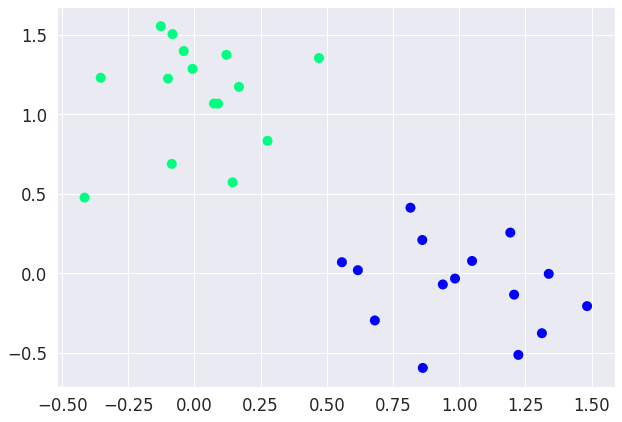

In [2]:
X, Y = make_blobs(n_samples=30, n_features=2, centers=[(1, 0), (0, 1)], 
                  cluster_std=0.3, random_state=21)

plt.figure(figsize=(10, 7))
plt.scatter(X[:, 0], X[:, 1], c=Y, linewidths=0, s=100, cmap='winter')
plt.grid()
plt.show()

Вспомогательная функция для отрисовки

In [3]:
def draw_graphics(models, X, Y, support_size=800, 
                  point_size=50, margin=False):
    '''
    Визуализирует решающие правила для каждой модели.
    models --- все обученные SVM-модели, которые нужно визуализировать.
    X --- объекты для визуализации (предполагается обучающая выборка)
    Y --- ответы для визуализации (предполагается обучающая выборка)
    X_test --- объекты, на которых необходимо посчитать качество
    Y_test --- соответствующие им ответы.
    point_size --- размер точки на графике
    ncol --- количество колонок у таблицы графиков
    margin --- если True, то визуализируется решающая функция, 
                иначе решающее правило
    params --- список параметров SVM, которые нужно напечатать на графике
    '''
    
    # определение количества строк таблицы графиков в зависимости
    # от количества колонок и количества моделей
    n_rows = (len(models) + 1) // 2
    
    plt.figure(figsize=(16, 7*n_rows))    
    for i_model, model in enumerate(models):
        plt.subplot(n_rows, 2, i_model+1)
        
        # Значения гиперпараметров
        C = model.get_params()['C']
        
        # Визуализация опорных векторов model.support_vectors_
        plt.scatter(
            model.support_vectors_[:, 0], model.support_vectors_[:, 1], 
            edgecolor='black', s=np.abs(model._dual_coef_) * support_size, 
            alpha=0.5, zorder=10, facecolor='none', linewidths=3
        )
        
        # Визуализация остальных точек
        plt.scatter(
            X[:, 0], X[:, 1], c=Y, zorder=10, s=point_size, alpha=0.7,
            cmap=plt.cm.Set3, edgecolor='black', linewidths=1.5
        )
        
        # печатаем коэффициенты для опорных векторов
        for number, support_vector in enumerate(model.support_vectors_):
            coef = model._dual_coef_[0, number]
            plt.text(
                support_vector[0] + 0.01, support_vector[1] + 0.01,
                '{:.2}'.format(coef), fontsize=18,
                bbox=dict(
                    facecolor='#FF3300' if np.abs(coef) == C else 'w', 
                    alpha=0.7
                ))
        
        # Определение границ графика
        x_min = X[:, 0].min() - 0.5
        x_max = X[:, 0].max() + 0.5
        y_min = X[:, 1].min() - 0.5
        y_max = X[:, 1].max() + 0.5

        # Сетка точек в пространстве
        XX, YY = np.mgrid[x_min:x_max:500j, y_min:y_max:500j]
        # Значения решающей функции для этой сетки.
        # Чтобы их получить, нужно передать матрицу размера (N, 2)
        Z = model.decision_function(np.c_[XX.ravel(), YY.ravel()])
        
        # Количество классов
        K = 2 if len(Z.shape) == 1 else Z.shape[-1]
        
        if K == 2:
            # Ответы -- вектор. Переводим их к размеру сетки
            Z = Z.reshape(XX.shape)
            
            # Отрисовка решающей функции
            if margin:
                plt.pcolormesh(XX, YY, Z, cmap=plt.cm.RdBu)
            else:
                plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Set3)
                
            # Отрисовка разделяющей прямой и разделяющей полосы
            plt.contour(
                XX, YY, Z, colors=['k', 'k', 'k'], 
                linestyles=['--', '-', '--'], 
                levels=[-1, 0, 1]
            )
        else:
            # Отрисовка решающей функции
            plt.pcolormesh(
                XX, YY, np.argmax(Z, axis=1).reshape(XX.shape), 
                cmap=plt.cm.Set3
            )
 
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)
        plt.xticks(())
        plt.yticks(())
        
        plt.title('$C$ = {}, kernel = {}'.format(
            C, model.get_params()['kernel']
        ))
        
    plt.tight_layout()
    plt.show()

Визуализируем результаты для SVM с линейным ядром.

На графике желтым и синим цветами показана оценка классов по построенному классификатору. Черная сплошная линия отвечает за разделяющую поверхность, пунктирные линии -- границы разделяющей полосы, определяемой моделью SVM. Для каждого опорного объекта указан коэффициент $\lambda_i$, с которым он входит в решающее правило. Красный цвет метки имеют объекты-нарушители, которые выходят за пунктирную линию. Для таких объектов $\lambda_i = C$ -- установленный гиперпараметр. Пограничные объекты имеют белый цвет метки, причем их значение $\lambda_i$ лежит в пределах от 0 до $C$, что полностью соответствует теории.

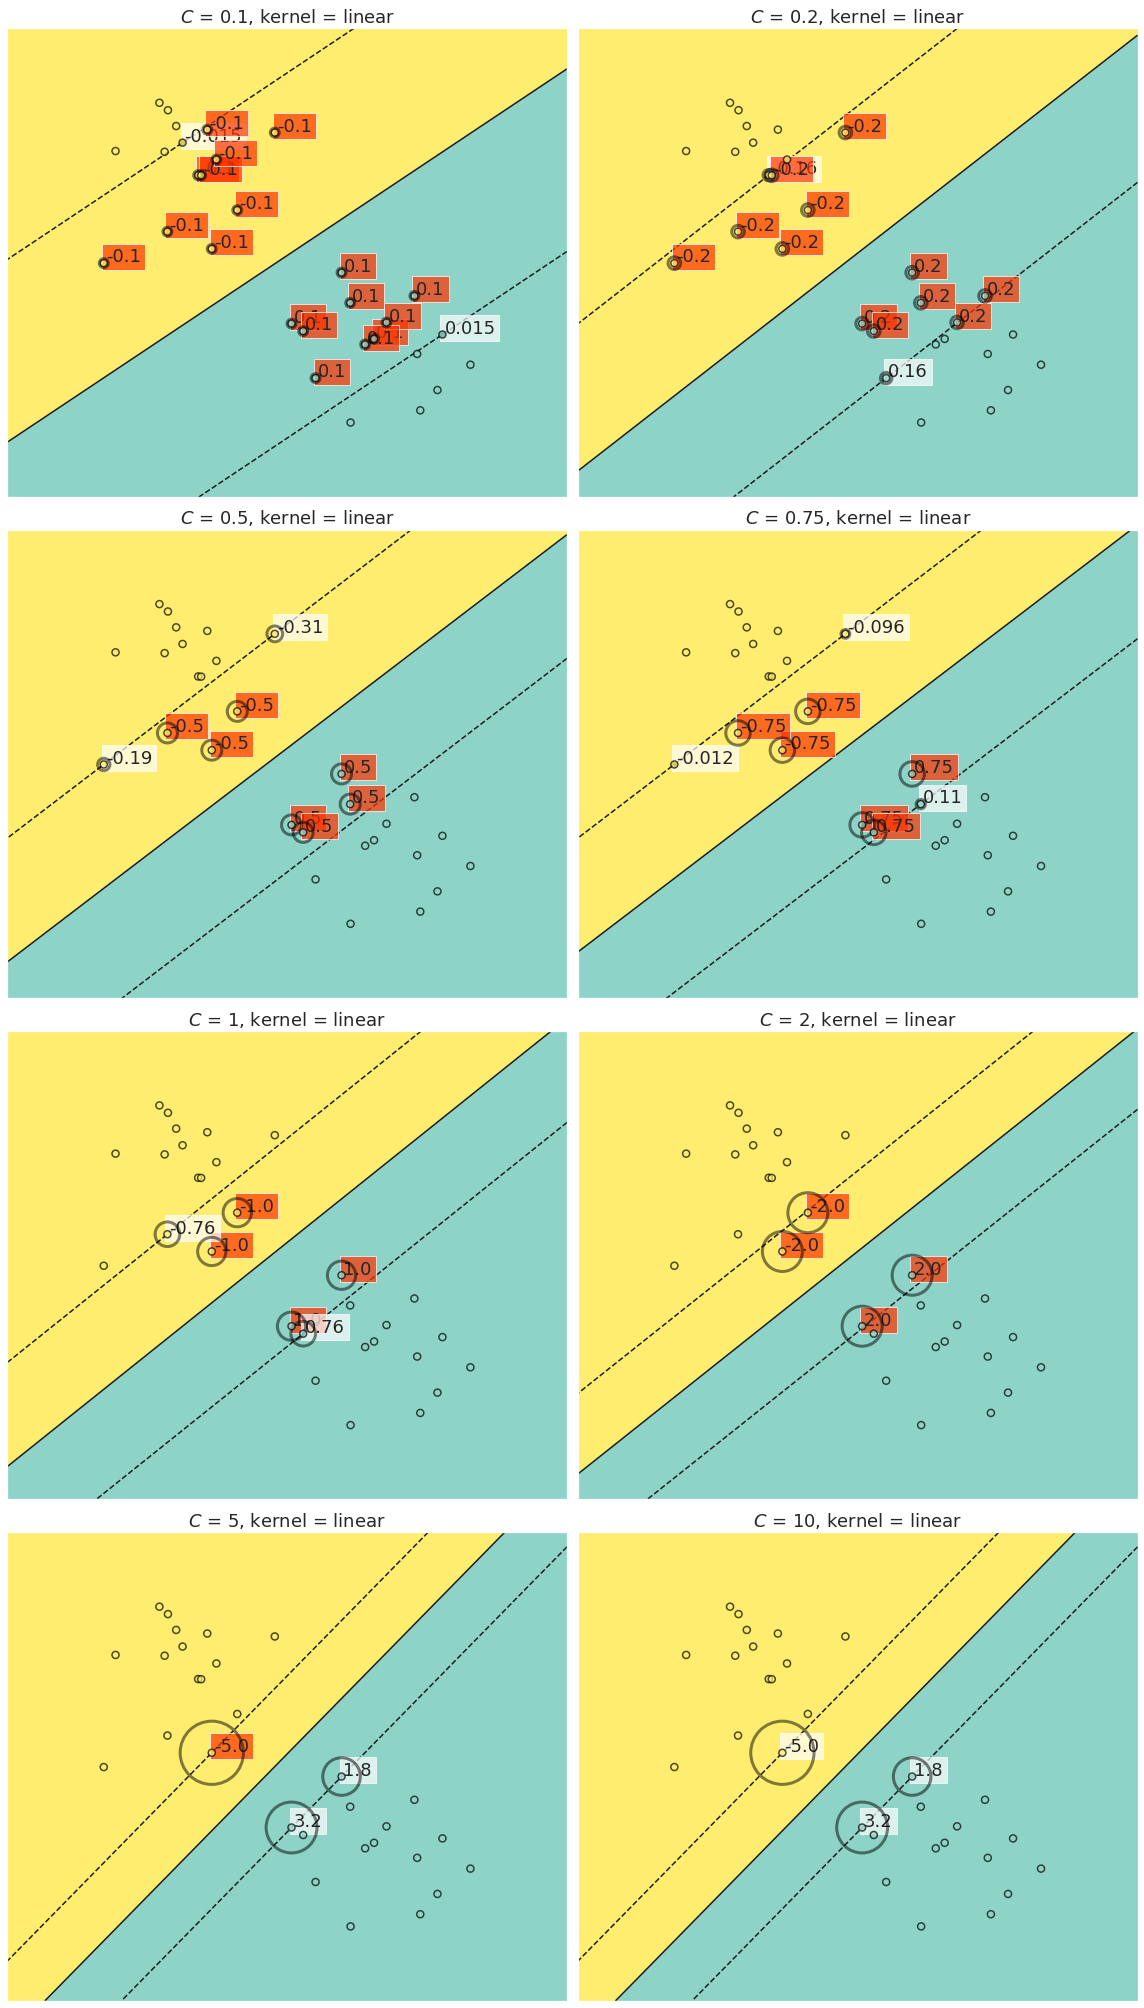

In [4]:
draw_graphics(
    [SVC(kernel='linear', C=C).fit(X, Y) 
     for C in [0.1, 0.2, 0.5, 0.75, 1, 2, 5, 10]], 
    X, Y
)

На следующих графиках цветом визуализирована решающая функция $f(x) = \left\langle \widehat{\theta}, x \right\rangle + \widehat{\theta}_0$.

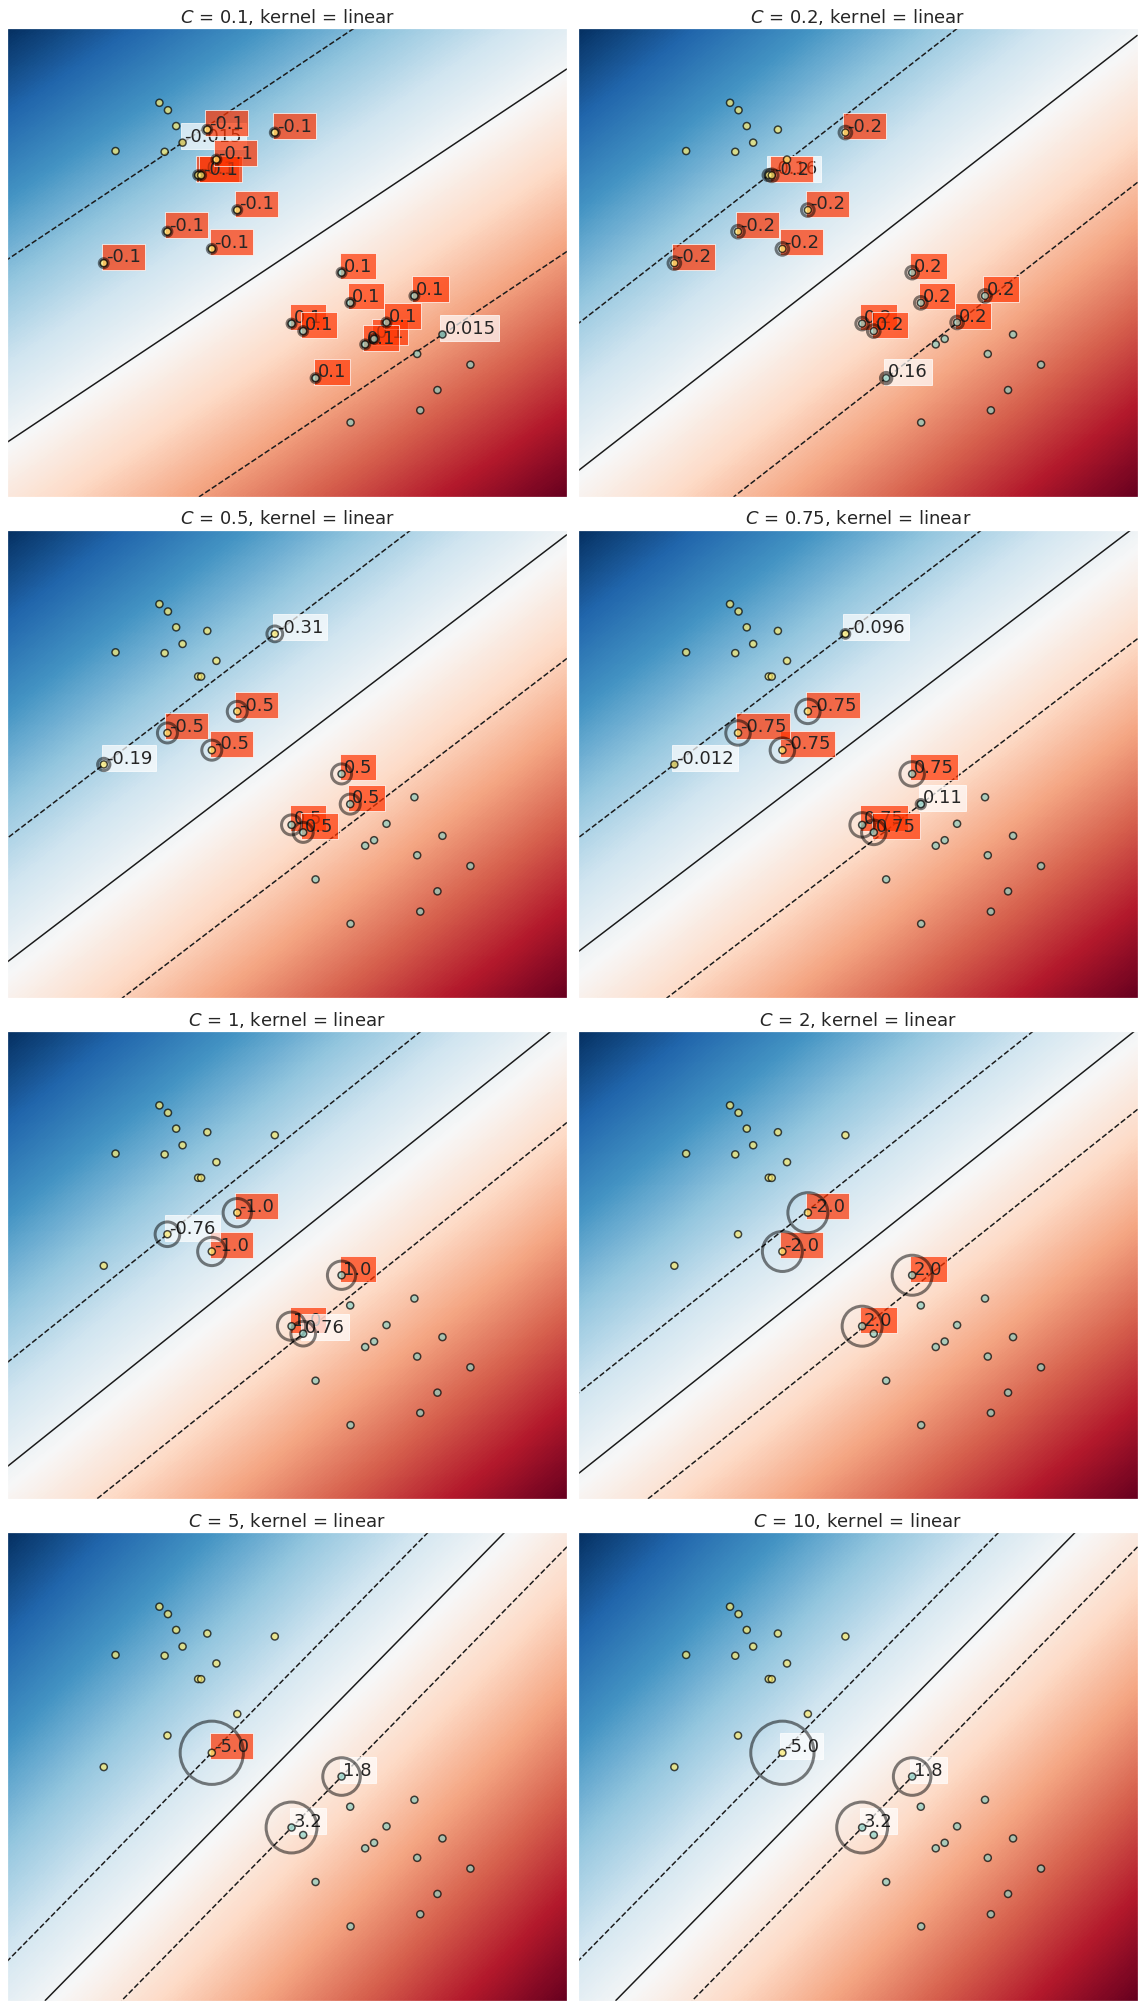

In [5]:
draw_graphics(
    [SVC(kernel='linear', C=C).fit(X, Y) 
     for C in [0.1, 0.2, 0.5, 0.75, 1, 2, 5, 10]], 
    X, Y, margin=True
)

Аналогично визуализируем результаты для SVM с линейным, полиномиальным и радиально базисным ядром:

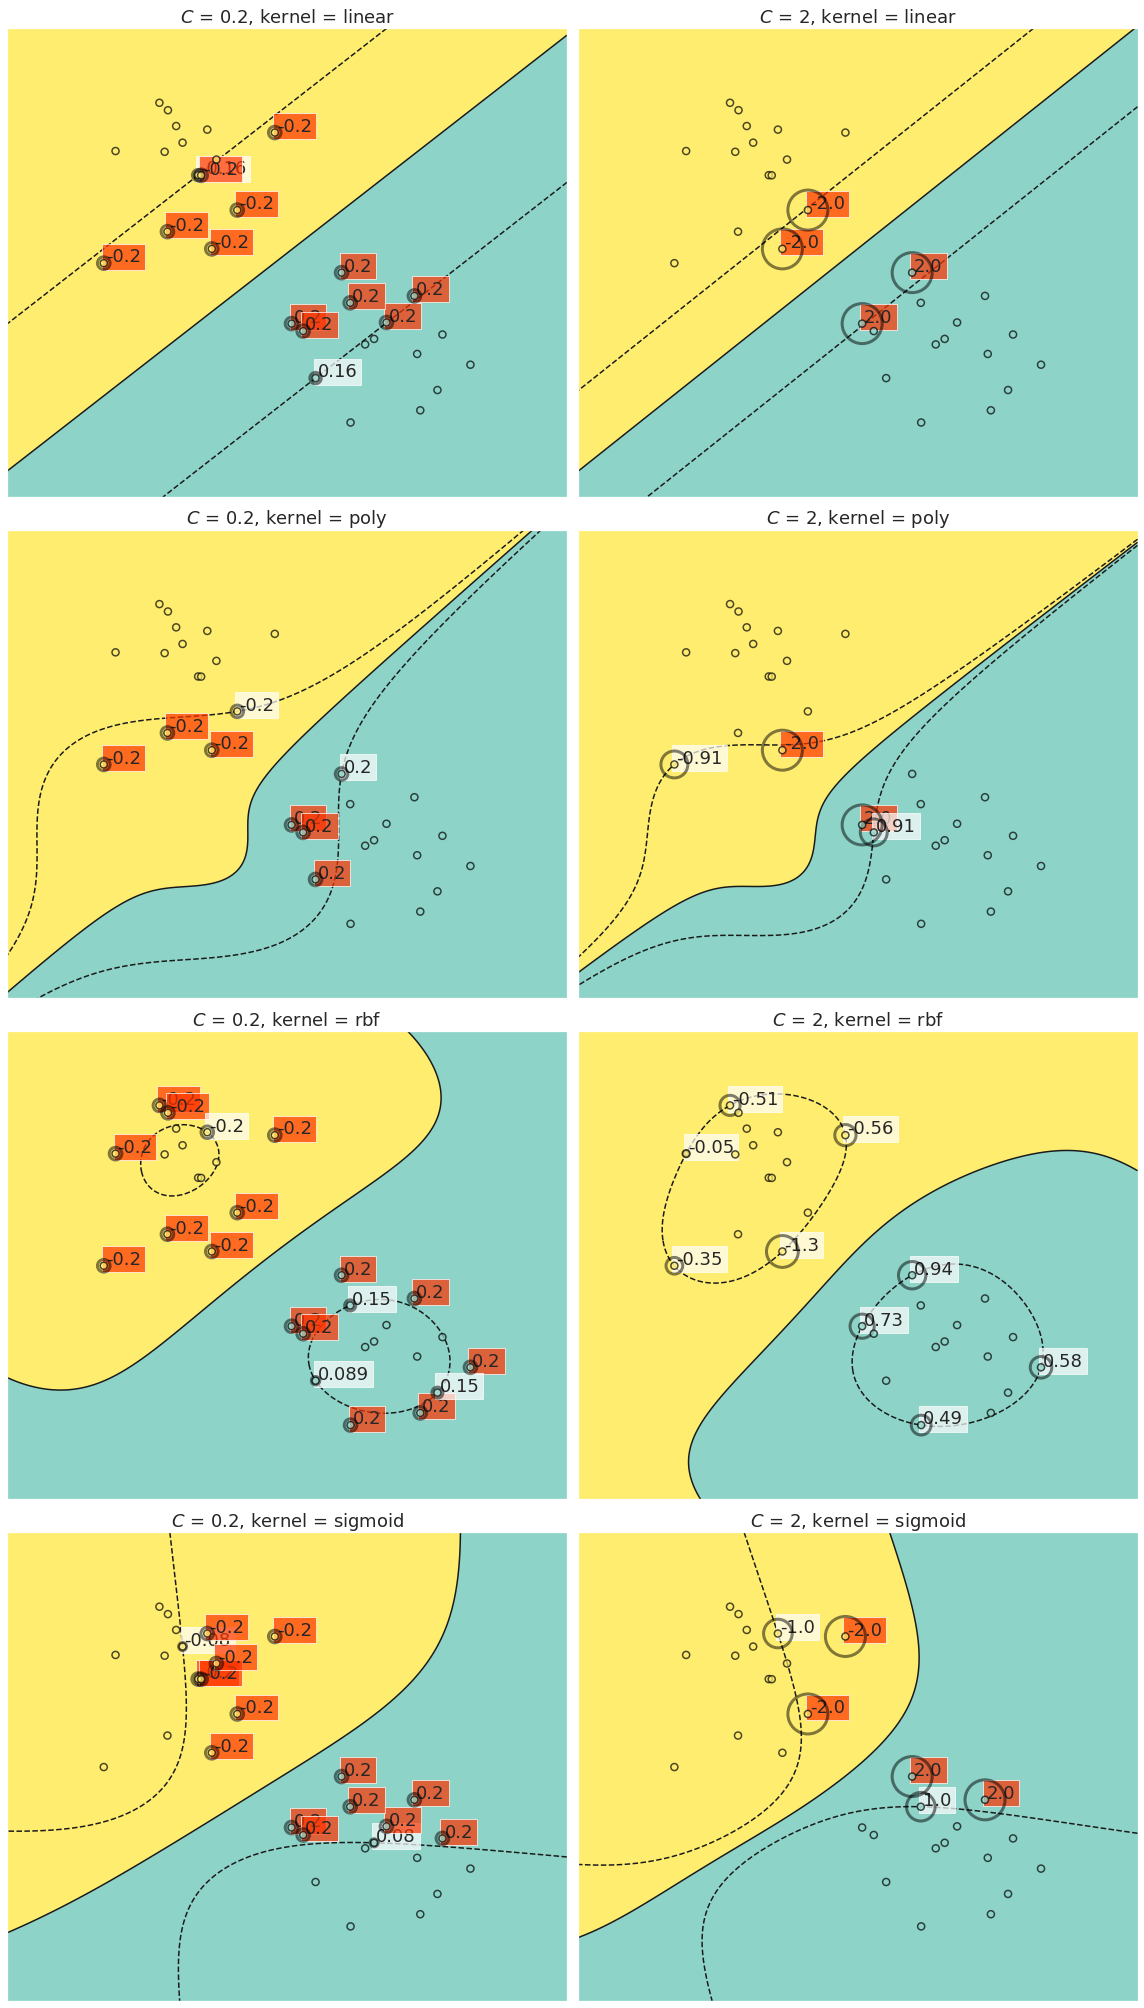

In [6]:
draw_graphics(
    [SVC(kernel=kernel, gamma=2, C=C).fit(X, Y) 
     for kernel in ('linear', 'poly', 'rbf', 'sigmoid') for C in [0.2, 2]], 
    X, Y
)

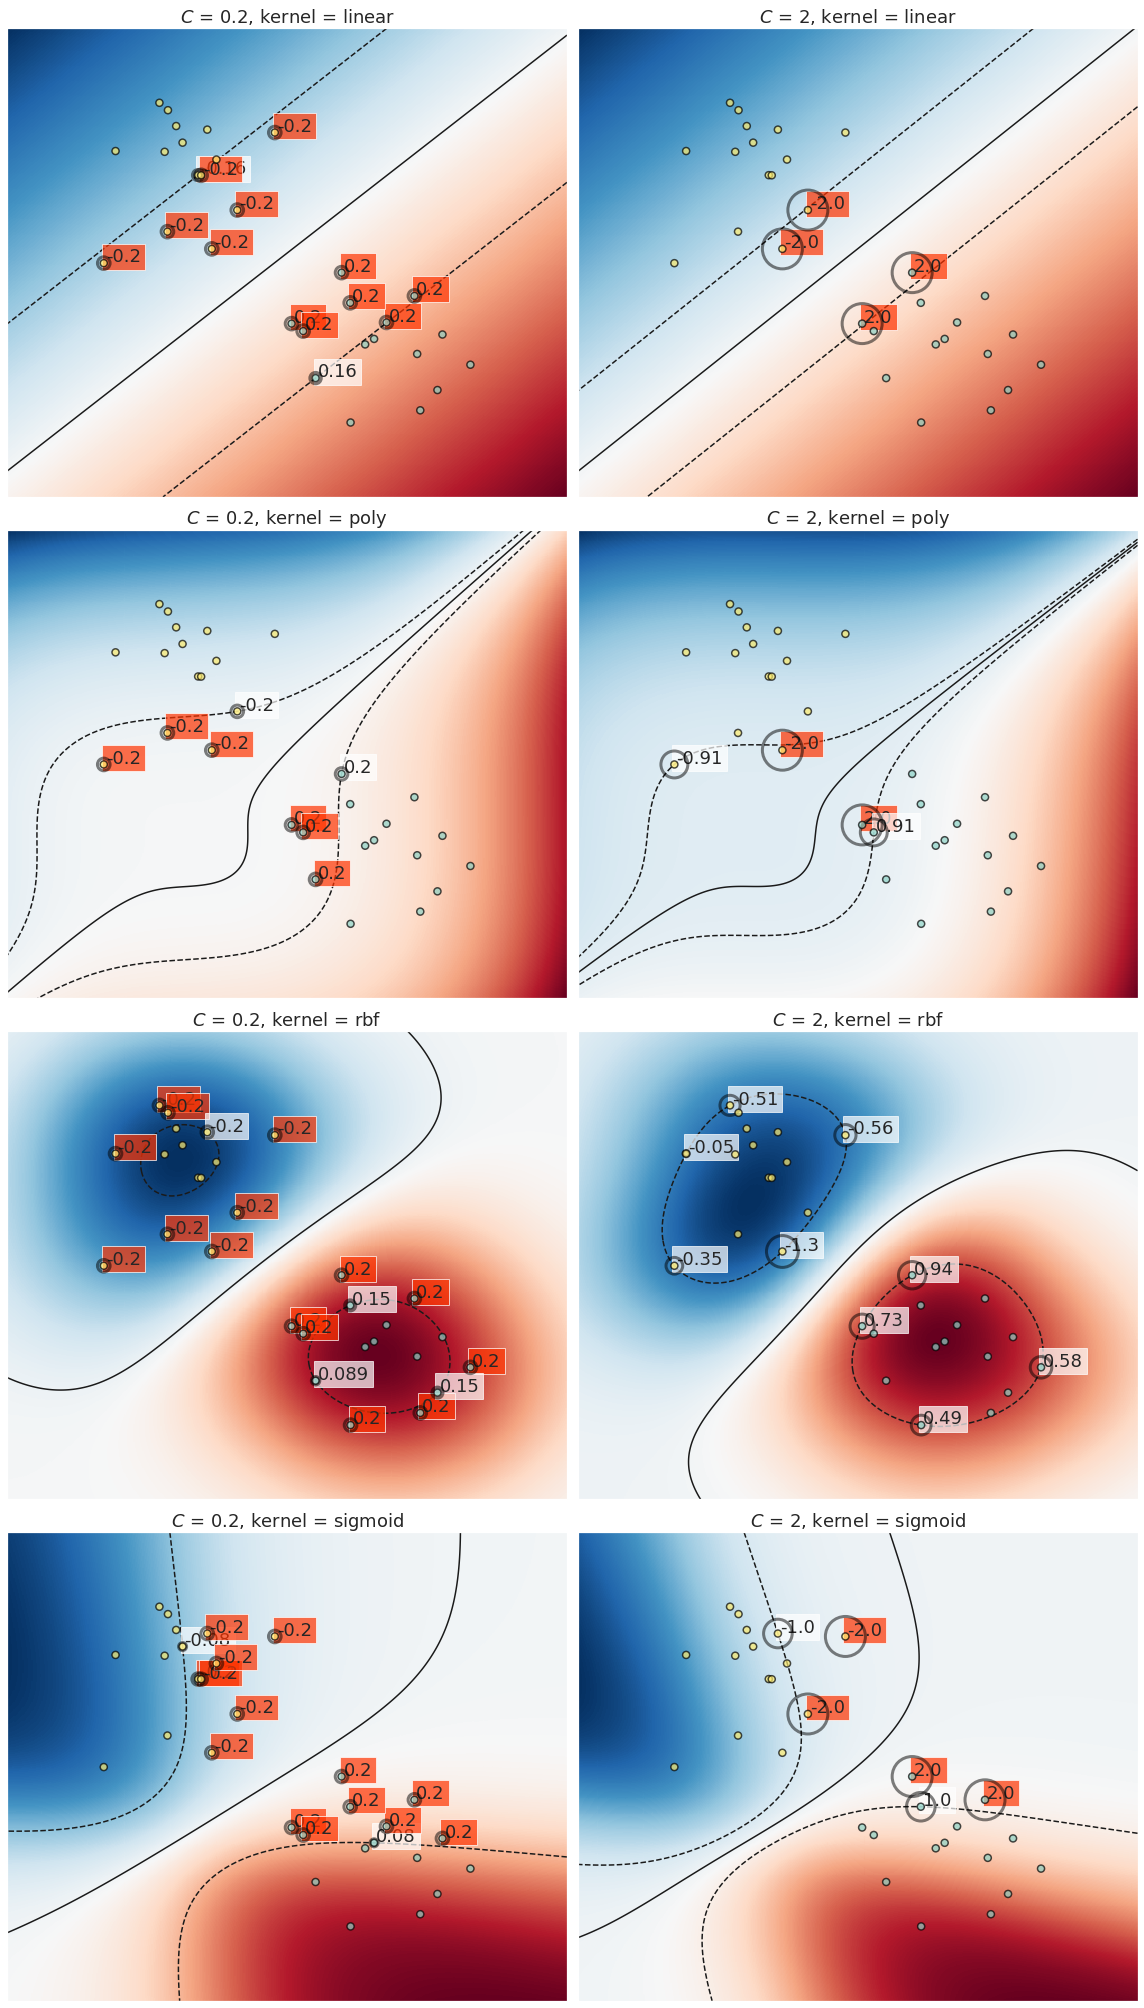

In [7]:
draw_graphics(
    [SVC(kernel=kernel, gamma=2, C=C).fit(X, Y) 
     for kernel in ('linear', 'poly', 'rbf', 'sigmoid') for C in [0.2, 2]], 
    X, Y, margin=True
)

Рассмотрим случай нескольких классов. Сгенерируем выборку

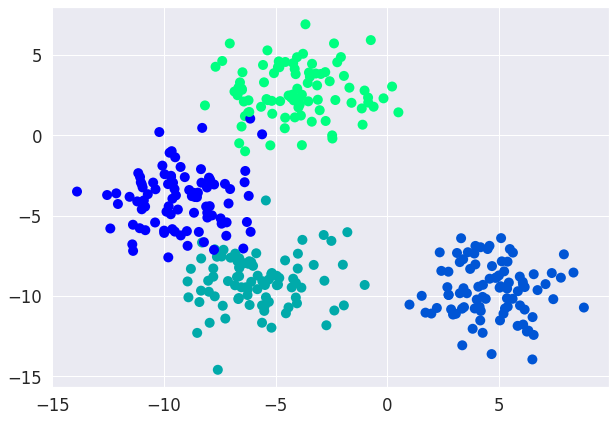

In [8]:
X, Y = make_blobs(n_samples=350, n_features=2, centers=4, 
                  cluster_std=1.7, random_state=21)

plt.figure(figsize=(10, 7))
plt.scatter(X[:, 0], X[:, 1], c=Y, linewidths=0, s=100, cmap='winter')
plt.grid()
plt.show()

Посмотрим на то, как SVM классифицирует такую выборку

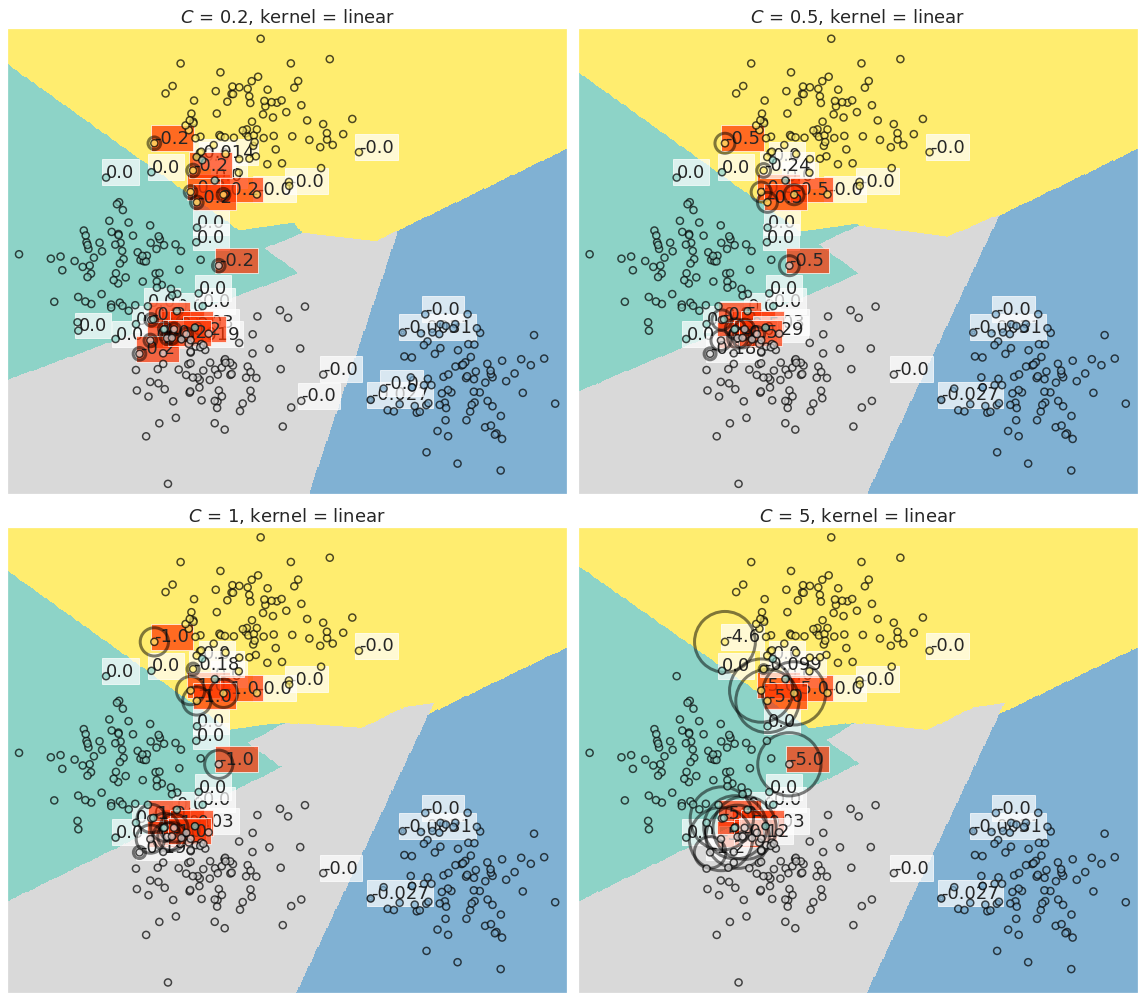

In [9]:
draw_graphics(
    [SVC(kernel='linear', C=C).fit(X, Y) 
     for C in [0.2, 0.5, 1, 5]], 
    X, Y
)

### Простые примеры регрессии

Сгенерируем выборку:

In [13]:
X = np.sort(5 * sps.uniform.rvs(size=(40, 1)), axis=0)
Y = np.sin(X).ravel()

Y[::5] += 3 * (0.5 - sps.uniform.rvs(size=8))

Инициализируем модели:

In [14]:
svr_lin = SVR(kernel='linear', C=100, gamma='auto').fit(X, Y)
svr_poly = SVR(kernel='poly', C=100, gamma='auto', 
               degree=3, epsilon=.1, coef0=1).fit(X, Y)
svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1).fit(X, Y)

Визуализируем результаты:

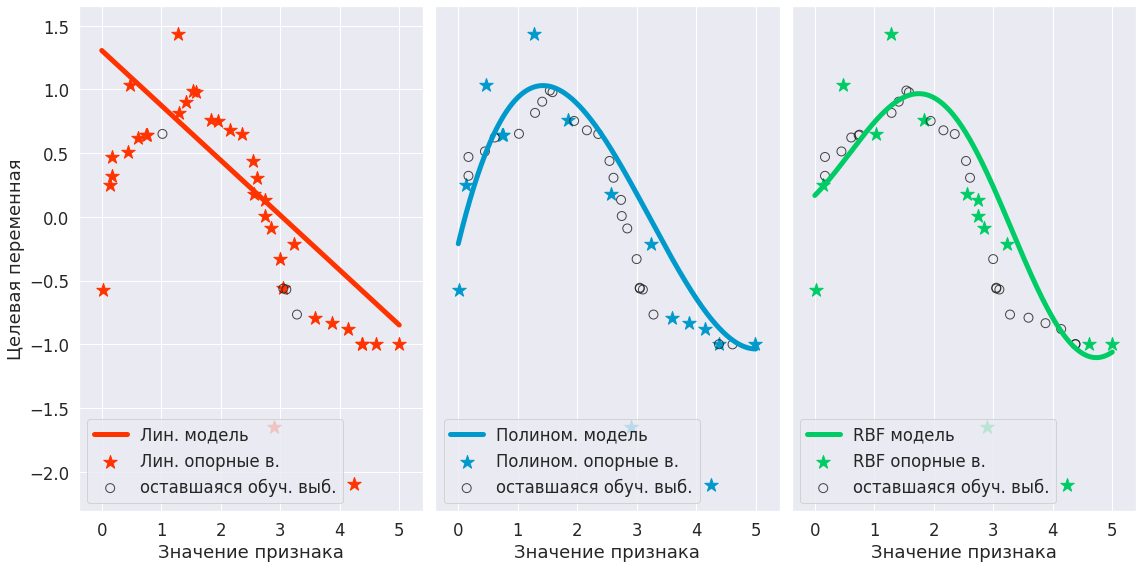

In [15]:
svrs = [svr_lin, svr_poly, svr_rbf]
kernel_label = ['Лин.', 'Полином.', 'RBF']
model_color = ['#FF3300', '#0099CC', '#00CC66']

plt.figure(figsize=(16, 8))
for ix, svr in enumerate(svrs):
    
    plt.subplot(1, 3, ix + 1)
    
    grid = np.linspace(0, 5, 1001).reshape((-1, 1))
    plt.plot(grid, svrs[ix].predict(grid), color=model_color[ix], lw=5,
            label='{} модель'.format(kernel_label[ix]))
    plt.scatter(X[svr.support_], y[svr.support_], marker='*', 
                color=model_color[ix], s=200,
                label='{} опорные в.'.format(kernel_label[ix]))
    plt.scatter(X[np.setdiff1d(np.arange(len(X)), svr.support_)],
                y[np.setdiff1d(np.arange(len(X)), svr.support_)],
                facecolor="none", edgecolor="k", s=80, alpha=0.8,
                label='оставшаяся обуч. выб.')

    plt.xlabel('Значение признака')
    if ix == 0:
        plt.ylabel('Целевая переменная')
    else:
        plt.yticks([])

    plt.legend(loc=3)
    plt.grid()

plt.tight_layout()
plt.show()

### Классификация автодорожных знаков

Рассмотрим задачу классификации изображений (многоклассовая классификация на 42 класса), а именно дорожных знаков.

Загрузим данные с диска: https://drive.google.com/file/d/115JLjH3nRg-FczEUM7mCx13olb6wTfiA/view

In [0]:
from google.colab import drive

drive.mount('/content/drive')

In [0]:
! unzip 'drive/My Drive/road_signs.zip'
! rm '00_test_img_input/train/gt.csv'

In [0]:
gt = pd.read_csv('00_test_img_gt/gt.csv', index_col='filename')
path = '00_test_img_input/train'

Посмотрим на распределение классов в выборке:

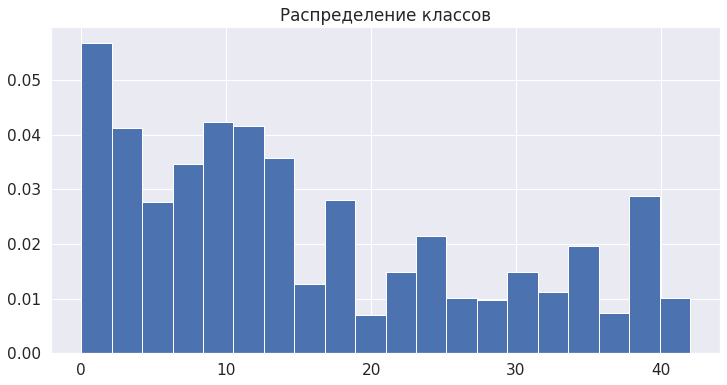

In [0]:
plt.figure(figsize=(12, 6))
gt.class_id.hist(density=True, bins=20)
plt.title('Распределение классов')
plt.show()

Видим, что явного дисбаланса классов нет.

Посмотрим на данные:

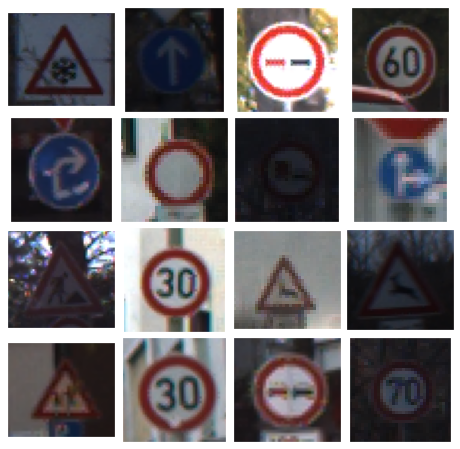

In [0]:
plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(4, 4)
gs.update(wspace=0.05, hspace=0.05)

for idx, img_path in enumerate(os.listdir(path)):

    if idx == 16:
        break

    img = PIL.Image.open(os.path.join(path, img_path))

    plt.subplot(gs[idx])
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

plt.show()

Теперь из каждой картинки получим [HOG дескрипторы](https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients), которые являются по сути признаками, на которых мы и будем учить классификатор.

Схема вычисления HOG:

1. Конвертация цветной картинки в черно-белую, путем взятия яркости изображения, как линейной комбинации каналов. (Точнее компоненты Y в формате [YCbCr](https://en.wikipedia.org/wiki/YCbCr#ITU-R_BT.601_conversion))

2. Вычисляются производные изображения $I_x$ и $I_y$ путем свертки c обычными разностными ядрами или ядрами Собеля:

$$D_x = (−1 \space 0 \space 1), D_y =(−1 \space 0 \space 1)^T,$$

$$S_x = \begin{pmatrix} -1 & 0 & 1\\ -2 & 0 & 2\\-1 & 0 & 1 \end{pmatrix}, S_y = \begin{pmatrix} 1 & 2 & 1\\ 0 & 0 & 0\\-1 & -2 & -1 \end{pmatrix}$$

3. Вычисляется модуль градиента и направление градиента по формуле:

$$|G| = \sqrt{I_x^2 + I_y^2}, \Theta = \text{atan2}{(I_y, I_x)}$$

$$\text{где atan2 — знаковый арктангенс, принимающий значения от −π до π.}$$

4. Изображение разбивается на ячейки размером `cell_rows` × `cell_cols` пикселей и для каждой ячейки строится гистограмма направлений c `bin_count` корзин. Пиксель ячейки входит в одну из корзин гистограммы с весом, равным модулю градиента в данном пикселе. В простейшем случае ячейки не пересекаются.

5. Ячейки объединяются в блоки размером `block_row_cells` × `block_col_cells`, блоки могут пересекаться. Гистограммы различных ячеек в блоке конкатенируются в вектор `v` и нормируются:

$$v = \frac{v}{\sqrt{|v|^2 + \epsilon}}$$

6. Конкатенация векторов v из всех блоков является дескриптором изображения.

In [0]:
def extract_hog(img, bins=9):
    """ Извлечение hog-дескрипторов из изображения. """

    # приводим картинки к одному и тому же размеру с помощью бикубик интерполяции
    img = img.resize((64, 64), resample=PIL.Image.BICUBIC)
    img = np.array(img, dtype=np.float32)

    # из трехканальной картинки получаем одноканальную, считая ее яркость
    brightness = 0.299 * img[:, :, 0] + 0.587 * img[:, :, 1] \
                 + 0.114 * img[:, :, 2]

    # считаем норму и угол градиента
    dx, dy = np.gradient(brightness)
    G = np.sqrt(dx ** 2 + dy ** 2)
    Theta = np.arctan2(dy, dx)

    # считаем гистограммы ориентированных градиентов
    cells = np.zeros((64, 9))
    for i in range(8):
        for j in range(8):
            hist, _ = np.histogram(
                a=Theta[i * 8:(i + 1) * 8, j * 8:(j + 1) * 8], 
                bins=bins, 
                range=(-np.pi, np.pi), 
                weights=G[i * 8:(i + 1) * 8, j * 8:(j + 1) * 8]
            )

            cells[8 * i + j] = hist

    cells = cells.reshape(-1)

    # нормировка
    for i in range(0, 64 * 9, 9):
        cells[i:i + 9] /= (np.linalg.norm(cells[i:i + 9], ord=2) + 1e-5)

    return cells

Теперь для каждой картинки посчитаем ее гистограмму ориентированных градиентов (в моем случае это вектор размерности 576) и сохраним все в память:

In [0]:
X = np.zeros((39209, 576))
y = np.zeros(39209)

for idx, img_path in enumerate(os.listdir(path)):
    img = PIL.Image.open(os.path.join(path, img_path)).convert('RGB')
    X[idx] = extract_hog(img)
    y[idx] = gt.loc[img_path].values[0]

Разделим выборку на обучающую и тестовую:

In [0]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

В данном случае обычный `SVC` будет очень долго работать, поэтому воспользуемся `LinearSVC`:

In [0]:
clf = LinearSVC(max_iter=5000)
clf.fit(X_train, y_train)

accuracy_score(y_test, clf.predict(X_test))

0.979979597041571

Без нейросетей и даже без подбора гиперпараметров мы получили очень высокое качество! Именно так и классифицировали изображения, когда не было нейросетей. Напоминаю, что было 42 класса, а мы получили качество 98%.
